# 🧠 Hybrid LSTM-GRU Model Training (Paper Aligned)

**Architecture Specs:**
1.  **Dual-Path**: Parallel LSTM and GRU branches.
2.  **Capacity**: 2 Layers, 64 Hidden Units, Dropout 0.3.
3.  **Fusion**: Concatenation -> Dense Layers.

**Robustness:**
1.  **Class Weights**: Handling imbalance (Baseline > Stress).
2.  **Scheduler**: Dynamic Learning Rate.

---

In [5]:
import os
import json
import pickle
import numpy as np
import torch
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.onnx
import scipy.stats
from scipy.signal import butter, sosfiltfilt, resample, welch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score, f1_score, roc_auc_score
from torch.utils.data import TensorDataset, DataLoader

# Setup
sns.set_style("whitegrid")
np.random.seed(42)
torch.manual_seed(42)

# Paths
CURRENT_DIR = os.getcwd()
PROJECT_ROOT = os.path.abspath(os.path.join(CURRENT_DIR, '..')) 
DATA_PATH = os.path.join(PROJECT_ROOT, 'datasets', 'WESAD', 'S2', 'S2.pkl')
MODEL_EXPORT_PATH = os.path.join(PROJECT_ROOT, 'public', 'model', 'hybrid_model.onnx')

# Hyperparameters
FS = 700
WINDOW_SECONDS = 5
SUB_WINDOW_SECONDS = 0.5  # 500ms frames for features
SUB_WINDOW_STEP = 0.25    # 250ms (50% overlap)
WINDOW_STEP = 1750 # 50% Overlap (Paper aligned)

# Samples
SEQ_LEN = int(FS * WINDOW_SECONDS) # 3500
FRAME_LEN = int(FS * SUB_WINDOW_SECONDS) # 350
FRAME_STEP = int(FS * SUB_WINDOW_STEP)   # 175

# Data Overlap (Sliding the 5s window) - increased for more data

BATCH_SIZE = 64
EPOCHS = 50       
PATIENCE = 10      
NOISE_FACTOR = 0.05 
HIDDEN_SIZE = 64 # Paper aligned

print(f"Project Root: {PROJECT_ROOT}")

Project Root: c:\Users\priya\Proj\anomaly-detection-web


## 1. Data Loading & Preprocessing

In [6]:
# --- 1. Data Loading ---
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Dataset not found at {DATA_PATH}")

print(f"Loading {DATA_PATH}...")
with open(DATA_PATH, 'rb') as file:
    data = pickle.load(file, encoding='latin1')

# Signals
ecg = data['signal']['chest']['ECG'].flatten()
eda = data['signal']['chest']['EDA'].flatten()
resp = data['signal']['chest']['Resp'].flatten()
acc = data['signal']['chest']['ACC']
bvp = data['signal']['wrist']['BVP'].flatten()

# Resample BVP
bvp = resample(bvp, len(ecg))

# --- 2. Preprocessing (SOS Filtering) ---
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    sos = butter(order, [lowcut, highcut], btype='band', fs=fs, output='sos')
    return sosfiltfilt(sos, data)

def clean(x):
    return np.nan_to_num(x, nan=np.nanmean(x) if not np.isnan(np.nanmean(x)) else 0.0)

print("Filtering signals...")
ecg = butter_bandpass_filter(clean(ecg), 0.5, 12, FS)
eda = butter_bandpass_filter(clean(eda), 0.5, 12, FS)
resp = butter_bandpass_filter(clean(resp), 0.5, 12, FS)
bvp = butter_bandpass_filter(clean(bvp), 0.5, 12, FS)
for i in range(3):
    acc[:, i] = butter_bandpass_filter(clean(acc[:, i]), 0.5, 12, FS)

# Normalize
def normalize(x):
    return (x - np.mean(x)) / (np.std(x) + 1e-6)

ecg = normalize(ecg)
eda = normalize(eda)
resp = normalize(resp)
bvp = normalize(bvp)
acc = (acc - np.mean(acc, axis=0)) / (np.std(acc, axis=0) + 1e-6)

# Labels
labels = data['label']
mask = np.isin(labels, [1, 2])
ecg, eda, resp, bvp, acc = ecg[mask], eda[mask], resp[mask], bvp[mask], acc[mask]
y = labels[mask]
y = np.where(y == 2, 1, 0).astype(np.float32)

# --- 3. Feature Extraction Functions ---
def get_rmssd(x):
    diff = np.diff(x)
    return np.sqrt(np.mean(diff**2))

def get_energy(x):
    return np.sum(x**2)

def get_entropy(x):
    # Spectral Entropy
    _, psd = welch(x, fs=FS, nperseg=len(x))
    psd_norm = psd / (np.sum(psd) + 1e-10)
    return -np.sum(psd_norm * np.log(psd_norm + 1e-10))

def get_dom_freq(x):
    f, psd = welch(x, fs=FS, nperseg=len(x))
    return f[np.argmax(psd)]

def extract_features_from_frame(frame_data):
    # frame_data shape: (FRAME_LEN, 7) -> ECG, EDA, RESP, ACCx, ACCy, ACCz, BVP
    feats = []
    # For each channel, extract 4 feats -> 7*4 = 28 features
    for ch in range(7):
        sig = frame_data[:, ch]
        feats.append(get_rmssd(sig))
        feats.append(get_energy(sig))
        feats.append(get_entropy(sig))
        feats.append(get_dom_freq(sig))
    return np.array(feats)

# --- 4. Sequence Creation with Feature Extraction ---
def create_feature_sequences(ecg, eda, resp, acc, bvp, y, seq_len, step, frame_len, frame_step):
    xs, ys = [], []
    
    # Pre-stack all channels: (N, 7)
    all_signals = np.column_stack((ecg, eda, resp, acc, bvp))
    
    print(f"Generating sequences from {len(y)} samples...")
    # Iterate main 5s windows
    for i in range(0, len(y) - seq_len, step):
        window_data = all_signals[i:i+seq_len] # (3500, 7)
        label = y[i+seq_len-1]
        
        # Sub-windowing (Frames)
        frame_feats = []
        for j in range(0, seq_len - frame_len + 1, frame_step):
            frame = window_data[j:j+frame_len]
            # Extract features for this frame
            f_vec = extract_features_from_frame(frame) # (28,)
            frame_feats.append(f_vec)
            
        xs.append(np.array(frame_feats)) # (Num_Frames, 28)
        ys.append(label)
        
    return np.array(xs, dtype=np.float32), np.array(ys, dtype=np.float32)

print("Starting Feature Extraction (This may take a moment)...")
X, Y = create_feature_sequences(ecg, eda, resp, acc, bvp, y, SEQ_LEN, WINDOW_STEP, FRAME_LEN, FRAME_STEP)

print(f"Input Shape: {X.shape}") 
# Expected: (Batch, Num_Frames, 28) 
# Num_Frames approx 19 for 5s/0.5s with 50% overlap

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

# Augmentation
noise = np.random.normal(0, NOISE_FACTOR, X_train.shape)
X_train_final = np.vstack((X_train, X_train + noise))
y_train_final = np.hstack((y_train, y_train))

# Loaders
train_loader = DataLoader(TensorDataset(torch.from_numpy(X_train_final).float(), torch.from_numpy(y_train_final).float()), 
                          batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()), 
                         batch_size=BATCH_SIZE, shuffle=False)

Loading c:\Users\priya\Proj\anomaly-detection-web\datasets\WESAD\S2\S2.pkl...
Filtering signals...
Starting Feature Extraction (This may take a moment)...
Generating sequences from 1231300 samples...
Input Shape: (702, 19, 28)


## 2. Updated Model Architecture (Dual-Path Aligned)

In [7]:
# --- 2. LSTM-GRU Hybrid Model (Feature Enhanced) ---
class HybridModel(nn.Module):
    def __init__(self, input_dim, hidden_size=64):
        super(HybridModel, self).__init__()
        
        # LSTM Path (2 Layers) - Increased Capacity
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_size, num_layers=2, batch_first=True, dropout=0.3)
        
        # GRU Path (2 Layers)
        self.gru = nn.GRU(input_size=input_dim, hidden_size=hidden_size, num_layers=2, batch_first=True, dropout=0.3)
        
        # Fusion -> Dense
        # Concat: hidden_size * 2
        self.fc1 = nn.Linear(hidden_size * 2, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # x shape: (Batch, Num_Frames, 28)
        lstm_out, _ = self.lstm(x)
        gru_out, _ = self.gru(x)
        
        # Pooling (Last Step)
        lstm_feat = lstm_out[:, -1, :]
        gru_feat = gru_out[:, -1, :]
        
        combined = torch.cat((lstm_feat, gru_feat), dim=1)
        
        x = self.fc1(combined)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        out = self.fc3(x)
        return out

INPUT_FEATS = X_train.shape[2] # Should be 28
model = HybridModel(input_dim=INPUT_FEATS, hidden_size=HIDDEN_SIZE)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4) # AdamW

num_neg = len(y[y==0])
num_pos = len(y[y==1])
pos_weight = torch.tensor([num_neg / num_pos])
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=EPOCHS)

## 3. Training Loop

In [8]:
# --- 3. Training Loop ---
best_val_loss = float('inf')
patience_counter = 0
train_history = []
val_history = []

print(f"Starting Training (Max Epochs: {EPOCHS})...")

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        running_loss += loss.item()
    
    avg_train = running_loss / len(train_loader)
    train_history.append(avg_train)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    avg_val = val_loss / len(test_loader)
    val_history.append(avg_val)
    
    print(f"Epoch {epoch+1:02d} | Train: {avg_train:.4f} | Val: {avg_val:.4f}")

    if avg_val < best_val_loss:
        best_val_loss = avg_val
        patience_counter = 0
        best_model_state = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"Early stopping at {epoch+1}")
            break

model.load_state_dict(best_model_state)

Starting Training (Max Epochs: 50)...
Epoch 01 | Train: 0.8838 | Val: 0.8219
Epoch 02 | Train: 0.7929 | Val: 0.6153
Epoch 03 | Train: 0.5220 | Val: 0.2524
Epoch 04 | Train: 0.3311 | Val: 0.3779
Epoch 05 | Train: 0.2269 | Val: 0.3137
Epoch 06 | Train: 0.2308 | Val: 0.3648
Epoch 07 | Train: 0.1660 | Val: 0.2292
Epoch 08 | Train: 0.1656 | Val: 0.2250
Epoch 09 | Train: 0.1778 | Val: 0.2664
Epoch 10 | Train: 0.4428 | Val: 0.2853
Epoch 11 | Train: 0.1615 | Val: 0.6263
Epoch 12 | Train: 0.1894 | Val: 0.3657
Epoch 13 | Train: 0.1751 | Val: 0.7072
Epoch 14 | Train: 0.2452 | Val: 0.4441
Epoch 15 | Train: 0.1579 | Val: 0.7897
Epoch 16 | Train: 0.2119 | Val: 0.2061
Epoch 17 | Train: 0.1617 | Val: 0.4292
Epoch 18 | Train: 0.1196 | Val: 0.6327
Epoch 19 | Train: 0.1563 | Val: 0.4284
Epoch 20 | Train: 0.2264 | Val: 0.2506
Epoch 21 | Train: 0.2179 | Val: 0.2163
Epoch 22 | Train: 0.1369 | Val: 0.1671
Epoch 23 | Train: 0.1398 | Val: 0.6023
Epoch 24 | Train: 0.1600 | Val: 0.2595
Epoch 25 | Train: 0.1291 |

<All keys matched successfully>

## 4. Evaluation


--- Model Performance Analysis ---


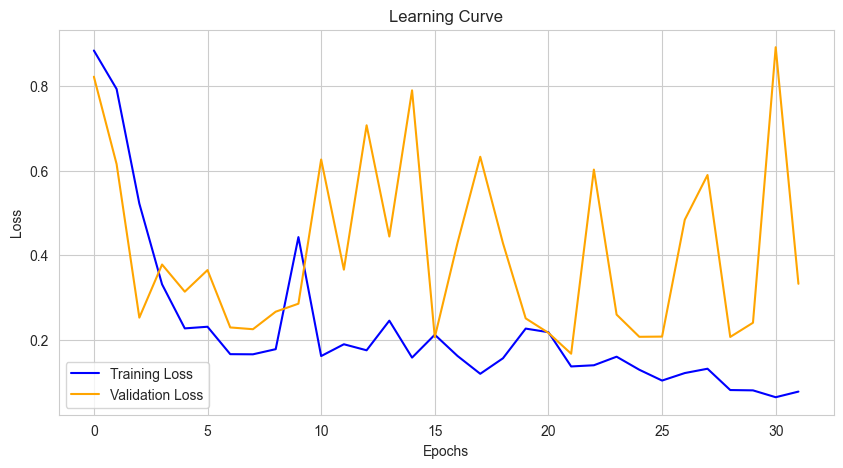

Optimal Threshold: 0.10


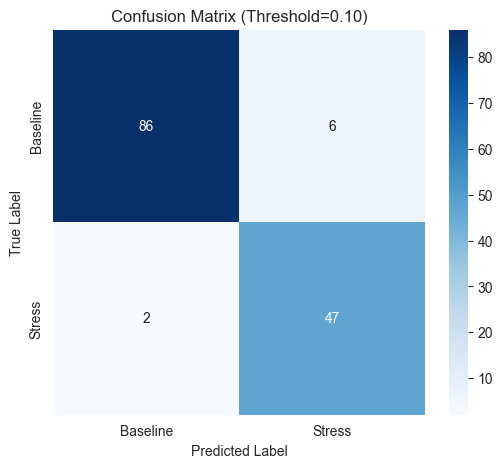

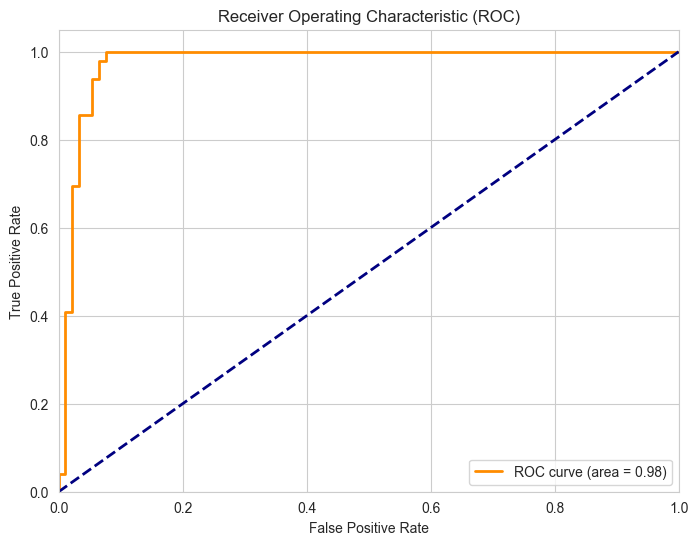

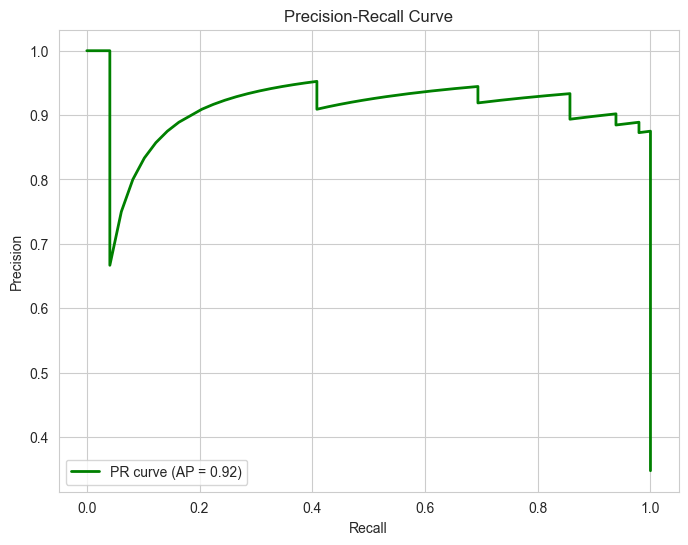

--- Final Verdict ---
              precision    recall  f1-score   support

    Baseline       0.98      0.93      0.96        92
      Stress       0.89      0.96      0.92        49

    accuracy                           0.94       141
   macro avg       0.93      0.95      0.94       141
weighted avg       0.95      0.94      0.94       141

AUC-ROC Score: 0.9758
Average Precision: 0.9162
✅ Model Quality: EXCELLENT (Highly separable classes)
✅ F1-Score indicates high accuracy on Stress detection.


In [11]:
# --- 4. Visualization & Analysis ---
print("\n--- Model Performance Analysis ---")
import matplotlib.pyplot as plt
# 1. Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(train_history, label='Training Loss', color='blue')
plt.plot(val_history, label='Validation Loss', color='orange')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Get Predictions
model.eval()
y_true, y_prob = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs).squeeze()
        probs = torch.sigmoid(outputs)
        y_prob.extend(probs.numpy())
        y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_prob = np.array(y_prob)

# Find Optimal Threshold
thresholds = np.arange(0.1, 0.9, 0.01)
best_f1 = 0
best_thresh = 0.5
for t in thresholds:
    y_pred_t = (y_prob > t).astype(float)
    f1 = f1_score(y_true, y_pred_t)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

print(f"Optimal Threshold: {best_thresh:.2f}")

# Final Predictions
y_pred_final = (y_prob > best_thresh).astype(float)

# 2. Confusion Matrix
cm = confusion_matrix(y_true, y_pred_final)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Baseline', 'Stress'], yticklabels=['Baseline', 'Stress'])
plt.title(f'Confusion Matrix (Threshold={best_thresh:.2f})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 3. ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# 4. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_prob)
avg_precision = average_precision_score(y_true, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2, label=f'PR curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

# Analysis Text
print("--- Final Verdict ---")
print(classification_report(y_true, y_pred_final, target_names=['Baseline', 'Stress']))
print(f"AUC-ROC Score: {roc_auc:.4f}")
print(f"Average Precision: {avg_precision:.4f}")

if roc_auc > 0.95:
    print("✅ Model Quality: EXCELLENT (Highly separable classes)")
elif roc_auc > 0.85:
    print("✅ Model Quality: GOOD (Strong performance, minor errors)")
else:
    print("⚠️ Model Quality: MODERATE/POOR (Needs improvement)")

if best_f1 > 0.90:
    print("✅ F1-Score indicates high accuracy on Stress detection.")
else:
    print("⚠️ F1-Score suggests struggle with False Positives/Negatives.")

# Export
os.makedirs(os.path.dirname(MODEL_EXPORT_PATH), exist_ok=True)
dummy_input = torch.randn(1, X_train.shape[1], X_train.shape[2])
torch.onnx.export(model, dummy_input, MODEL_EXPORT_PATH, input_names=['input'], output_names=['output'], dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}})
print(f"Model exported to {MODEL_EXPORT_PATH}")

In [12]:
# Export
os.makedirs(os.path.dirname(MODEL_EXPORT_PATH), exist_ok=True)

# Define Wrapper for Probability Output
class ExportModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        return self.sigmoid(self.model(x))

# Export Wrapped Model
export_model = ExportModel(model)
export_model.eval()

dummy_input = torch.randn(1, X_train.shape[1], X_train.shape[2])

# Export with Opset 12 for better Web compatibility
torch.onnx.export(
    export_model, 
    dummy_input, 
    MODEL_EXPORT_PATH, 
    input_names=['input'], 
    output_names=['output'], 
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}},
    opset_version=12
)
print(f"Model exported to {MODEL_EXPORT_PATH} (with Sigmoid & Opset 12)")

C:\Users\priya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\onnx\symbolic_opset9.py:4279: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(
C:\Users\priya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\onnx\symbolic_opset9.py:4279: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with GRU can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


Model exported to c:\Users\priya\Proj\anomaly-detection-web\public\model\hybrid_model.onnx (with Sigmoid & Opset 12)
